# Data Construction

由于模型需要合并tensor，但是cpu无法一次性跑出，跑一会就会死机。故每次处理1000图片保存，便清空数组，使得能够正常的构建训练数据集。代码可见Data.ipynb

# Train Model

在训练模型我们主要利用的是ClipCap对应的[github仓库](https://github.com/rmokady/CLIP_prefix_caption), 利用其对应的train文件，修改其中的参数为我们所用。

# ClipCap and YOLOClipCapModel

## Imports

In [9]:
import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup,GPT2Config
from tqdm import tqdm, trange
import skimage.io as io
import PIL.Image
from IPython.display import Image

N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'model_wieghts.pt')


## Model

In [10]:
class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 1024):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained("/data/lab/STA-AS2/myhead/")
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))
            
class ClipCaptionModel2(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel2, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained("/data/lab/STA-AS2/myhead/")
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))

class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [11]:
def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

## Load ClipCap and YoLoClipCap Model

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("/data/lab/STA-AS2/my/")
prefix_length = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ClipCaptionModel(prefix_length)
model.load_state_dict(torch.load("/data/lab/STA-AS2/coco_prefix-019 (1).pt", map_location=CPU),strict=False)

model2 = ClipCaptionModel2(prefix_length)
model2.load_state_dict(torch.load("/data/lab/STA-AS2/origin19.pt", map_location=CPU),strict=False)

model = model.eval()
model2 = model2.eval()
model = model.to(device)
model2 = model2.to(device)

**加载coco caption的数据集**

In [57]:
import pandas as pd
import pyarrow.parquet as pq
from PIL import Image
import io

# 读取 Parquet 文件,里面存储的Coco数据集
parquet_file_path = "/data/lab/STA-AS2/Orogindata/train-0.parquet"
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

**加载yolo的数据集**

In [59]:
import json

# JSON文件路径
json_file_path = "/data/lab/STA-AS2/big_yolo_train.json"

# 打开并读取JSON文件
with open(json_file_path, 'r') as json_file:
    xuanzi = json.load(json_file)

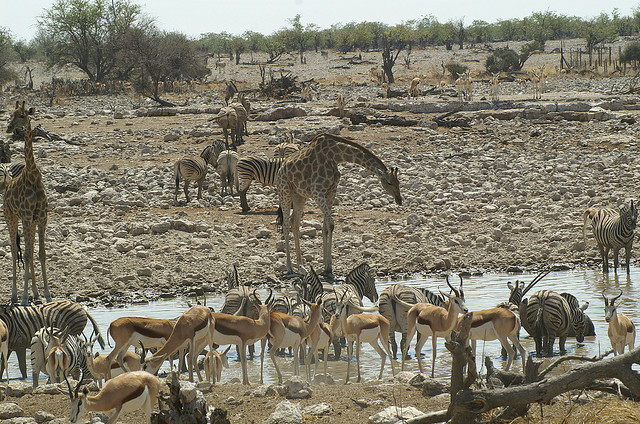

yolo:There are many zebra, giraffe, in the picture
Ground truth:Antelopes, zebras, and giraffes are gathered around the watering hole. 


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

clip:A group of giraffes standing next to each other.
clip_base:A herd of zebra standing next to each other in a field.


In [60]:
row = df.loc[1679]
image_data_dict = row["image"] 
image_data = image_data_dict.get("bytes", None)  # 获取二进制图像数据
image = Image.open(io.BytesIO(image_data))
image.show()
image = preprocess(image).unsqueeze(0).to(device)
imageid = row["cocoid"]
with torch.no_grad():
    prefix = clip_model.encode_image(image).to(device)

more = xuanzi[str(imageid)]
ground =row["sentences_raw"][0]
print(f"yolo:{more}")
print(f"Ground truth:{ground}")
text = clip.tokenize(more).to(device)
text_features = clip_model.encode_text(text)

prefix_more = torch.cat((prefix.float(),text_features.float()),dim=1)



prefix_embed = model.clip_project(prefix_more).reshape(1, prefix_length, -1)
prefix_base  = model2.clip_project(prefix.float()).reshape(1, prefix_length, -1)

generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
generated_text_prefix_base = generate2(model2, tokenizer, embed=prefix_base)

print(f"clip:{generated_text_prefix}")
print(f"clip_base:{generated_text_prefix_base}")

### Model Use Test Data

In [ ]:
answer=[]
answer_yoclip=[]
answer_clip=[]

for i in range(df.shape[0]):
    row = df.loc[1200]
    image_data_dict = row["image"] 
    image_data = image_data_dict.get("bytes", None)  # 获取二进制图像数据
    image = Image.open(io.BytesIO(image_data))
    image = preprocess(image).unsqueeze(0).to(device)
    imageid = row["cocoid"]
    with torch.no_grad():
        prefix = clip_model.encode_image(image).to(device)

    more = xuanzi[str(imageid)]
    ground =row["sentences_raw"]

    answer.append(ground)
    text = clip.tokenize(more).to(device)
    text_features = clip_model.encode_text(text)

    prefix_more = torch.cat((prefix.float(),text_features.float()),dim=1)



    prefix_embed = model.clip_project(prefix_more).reshape(1, prefix_length, -1)
    prefix_base  = model2.clip_project(prefix.float()).reshape(1, prefix_length, -1)

    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
    generated_text_prefix_base = generate2(model2, tokenizer, embed=prefix_base)
    answer_clip.append(generated_text_prefix_base)
    answer_yoclip.append(generated_text_prefix)

### SCORE

由于此处docker无法连入Hugging Face，故算分是在本地的机器跑，见Score.ipynb